<a href="https://colab.research.google.com/github/ycu-engine/kaggle/blob/main/nlp-getting-started/yuta-ura1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggleセットアップ

1. KaggleのAPIキーのアップロードをする

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuutaura","key":"892b29d8bbf181424abe2b1596c94ccb"}'}

2. Pathの設定

In [ ]:
!mkdir -p ~/.kaggle
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle/

3. kaggleライブラリのインストール

In [ ]:
!pip install kaggle

## データセットのダウンロード

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 65.4MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 17.5MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 132MB/s]


In [ ]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


# 基礎分析

## ライブラリのimport

In [ ]:
# 統計処理
import numpy as np
import pandas as pd

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
 

## データの読み込み

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 基本統計量の確認

## データ数

In [ ]:
print(f'train: {len(train)}\n', train.count())
print(f'\ntest: {len(test)}\n', test.count())

train: 7613
 id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

test: 3263
 id          3263
keyword     3237
location    2158
text        3263
dtype: int64


- `id`には欠損なし
- `keyword`は1%程度欠損
- `location`は33%程度欠損
- `text`は欠損なし
- `target`は欠損なし

## 目的変数の確認

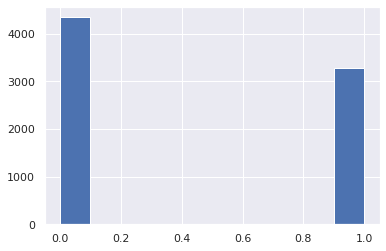

In [ ]:
train.target.hist()

`target = 0`の方が多いが、極端な差はない。

## keywordの確認

In [ ]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

いろいろ種類があるが、中に`%20`がある。

これは空白をURLエンコードしたものなので、複数のキーワードを持っているということになる。

In [ ]:
import typing as t

def split_keyword(keyword: str) -> t.List[str]:
    return keyword.split('%20') if keyword else []

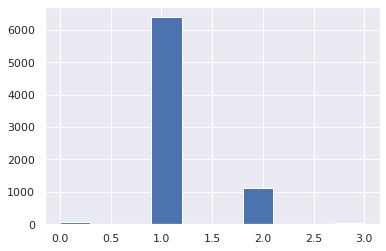

In [ ]:
train.keyword.fillna('').apply(split_keyword).apply(lambda array: len(array)).hist()

`keyword`はほとんどが1でごく稀に０個、十数％が2つとなっている。

`keyword`の個数と`target`の関係を見てみる

In [ ]:
print('個数')
display(pd.crosstab(train.target, train.keyword.fillna('').apply(split_keyword).apply(lambda array: len(array))))

print('ターゲット内の割合(%)')
display(pd.crosstab(train.target, train.keyword.fillna('').apply(split_keyword).apply(lambda array: len(array)), normalize='index').round(4)*100)

print('キーワードの割合(%)')
display(pd.crosstab(train.keyword.fillna('').apply(split_keyword).apply(lambda array: len(array)), train.target, normalize='index').round(4)*100)

個数


keyword,0,1,2,3
target,,,,
0,19,3838,480,5
1,42,2549,652,28


ターゲット内の割合(%)


keyword,0,1,2,3
target,,,,
0,0.44,88.39,11.05,0.12
1,1.28,77.93,19.93,0.86


キーワードの割合(%)


target,0,1
keyword,,
0,31.15,68.85
1,60.09,39.91
2,42.40,57.60
3,15.15,84.85


`keyword`３個もごくごく稀にありました。

`keyword`の個数が
- 0個 -> 災害の割合が２倍以上
- 1個 -> 災害の割合は低い
- 2個 -> ぶっちゃけ半々
- 3個 -> 災害の割合がめっちゃ高い

とはいえ、`keyword`が0個,3個のパターンは少ないのでなんとも言えない感じですが、データとして利用する価値はある。

### keywordの深堀り

例えば

- `ablaze, accident`と`ablaze`、`accident, ablaze`はデータとしては異なるが同じように扱ってもいいはず。

keywordを

In [ ]:
uniq_keyword = set()

for keywords in train[train.keyword.notnull()].keyword.apply(split_keyword):
    for keyword in keywords:
        uniq_keyword.add(keyword)

print(len(uniq_keyword))
uniq_keyword

229


{'ablaze',
 'accident',
 'aftershock',
 'airplane',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'bag',
 'bagging',
 'bags',
 'bang',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown',
 'body',
 'bomb',
 'bombed',
 'bomber',
 'bombing',
 'bridge',
 'buildings',
 'burned',
 'burning',
 'bush',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical',
 'cliff',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'desolation',
 'destroy',
 'destroyed',
 'destruction',
 'detonate',
 'detonation',
 'devastated',
 'devastation',

229種のキーワードがあった。

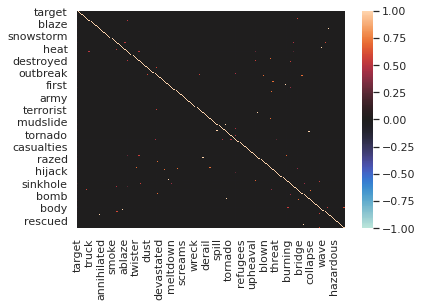

In [ ]:
splited_keyword = train.keyword.fillna('').apply(split_keyword)
_uniq_keywords = list(uniq_keyword)
target_keyword_corr = pd.concat([train.target, *[splited_keyword.apply(lambda keywords: 1 if keyword in keywords else 0) for keyword in _uniq_keywords]], axis=1, keys=['target', *_uniq_keywords]).corr()
sns.heatmap(target_keyword_corr, vmax=1, vmin=-1, center=0)

# target_keyword_corr[(target_keyword_corr.abs() > 0.3) & (target_keyword_corr.abs() < 1)].stack()

あまり見やすくないので相関が高めの物だけに絞り込む

In [ ]:
target_keyword_corr.target.reindex(target_keyword_corr.target.abs().sort_values(ascending=False).index).head()

target     1.000000
suicide    0.120536
bombing    0.095542
body      -0.087851
fires      0.084874
Name: target, dtype: float64

`target`と直接相関の高いものはなさそう。

- suicide(自殺)はかろうじて0.1より大きい程度

あまり`keyword`の要素では分けられなさそう。

## locationの確認

In [ ]:
print(len(train.location.unique()))
train.location.unique()

3342


array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

約3300の地域がある。ただ、中には`Est. September 2012 - Bristol`のように純粋な地名になっていないものもある。

結構雑なデータで地名という特性上抜き出すのは困難なので、使わないことにする。

## textの確認

textはもっとも自由度が高く、前処理の方法も色々考えられそうだ。まずはいくつかのtextを見てみる

In [ ]:
train.text.head(50)

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

すると、`@bbcmtd`のようになにかのメンションのようなものや、`http://t.co/rOI2NSmEJJ`のようにリンクになっているもの、`#metal`,`#RT`のようにハッシュタグになっているものもある。

これらは言葉としては意味のないものなので除去してあげる必要がある。リンクはリンクとしての情報しかないが、メンション先、ハッシュタグの内容などは利用できる可能性がある。

In [ ]:
import re

def text_to_mentions(text: str):
    return list(map(lambda x: x[1:],re.findall(r'@[a-zA-Z0-9_\-]+', text)))

def text_remove_mentions(text: str):
    return re.sub(r'@[a-zA-Z0-9_\-]+', '', text)

def text_has_url(text: str):
    return re.findall(r'https?://[a-zA-Z0-9./_\-]+', text)

def text_remove_url(text: str):
    return re.sub(r'https?://[a-zA-Z0-9./_\-]+', '', text)

def text_to_hashtags(text: str):
    return list(map(lambda x: x[1:].lower(),re.findall(r'#[a-zA-Z0-9_\-]+', text)))

def text_remove_hashtags(text: str):
    return re.sub(r'#[a-zA-Z0-9_\-]+', '', text)

mentions
2009


31                        [bbcmtd]
36                    [PhDSquares]
43                [southridgelife]
54                [Alexis_Sanchez]
63           [Navista7, News24680]
                   ...            
7577                     [widda16]
7578    [jt_ruff23, cameronhacker]
7581                  [engineshed]
7596                [LivingSafely]
7609    [aria_ahrary, TheTawniest]
Name: text, Length: 2009, dtype: object


hashtag
1743


0                         [earthquake]
3                          [wildfires]
4                  [alaska, wildfires]
5       [rockyfire, cafire, wildfires]
6                    [flood, disaster]
                     ...              
7598        [bathandnortheastsomerset]
7599              [earthquake, iphone]
7601                    [breaking, la]
7604                       [worldnews]
7607                      [stormchase]
Name: text, Length: 1743, dtype: object


url
31                             [http://t.co/lHYXEOHY6C]
32                             [http://t.co/YAo1e0xngw]
33                             [http://t.co/2nndBGwyEi]
35                             [http://t.co/qqsmshaJ3N]
37                             [http://t.co/3ImaomknnA]
38                             [http://t.co/wDUEaj8Q4J]
40    [http://t.co/rOI2NSmEJJ, http://t.co/3Tj8ZjiN2...
44                             [http://t.co/o9qknbfOFX]
45                             [http://t.co/TIyUliF5c6]
46                             [http://t.co/vl5TBR3wbr]
Name: text, dtype: object


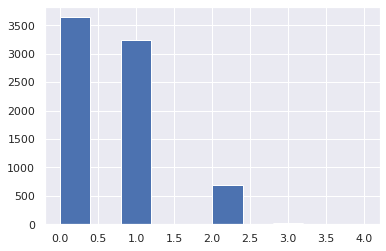

In [ ]:
text_mentions = train.text.apply(text_to_mentions)
text_url = train.text.apply(text_has_url)
text_hashtags = train.text.apply(text_to_hashtags)

print('mentions')
print(text_mentions[text_mentions.apply(lambda x: len(x)) > 0].count())
display(text_mentions[text_mentions.apply(lambda x: len(x)) > 0])

print('\nhashtag')
print(text_hashtags[text_hashtags.apply(lambda x: len(x)) > 0].count())
display(text_hashtags[text_hashtags.apply(lambda x: len(x)) > 0])

print('\nurl')
print(text_url[text_url.apply(len) > 0].head(10))
text_url.apply(len).hist()

メンションがあるものは約25%で、ハッシュタグのあるものは約22%となっている。

また、投稿の半分以上にurlを含んでいることがわかった。

### mentionとtargetの関係

In [ ]:
uniq_mention = set()

for mentions in text_mentions:
    for mention in mentions:
        uniq_mention.add(mention)

uniq_mention = list(uniq_mention)
print(len(uniq_mention))

2326


全部で2283種類のメンションがあることがわかった。

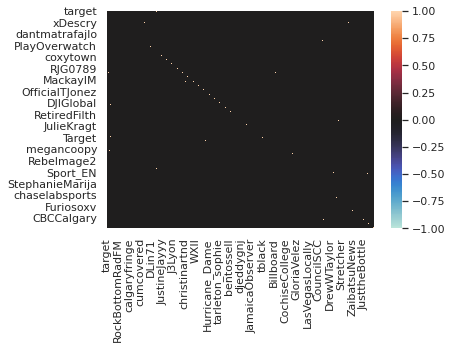

In [ ]:
target_text_mentions_corr = pd.concat([train.target, *[text_mentions.apply(lambda mentions: 1 if mention in mentions else 0) for mention in uniq_mention]], axis=1, keys=['target', *uniq_mention]).corr()
sns.heatmap(target_text_mentions_corr, vmax=1, vmin=-1, center=0)

# target_keyword_corr[(target_keyword_corr.abs() > 0.3) & (target_keyword_corr.abs() < 1)].stack()

In [ ]:
target_text_mentions_corr.target.reindex(target_text_mentions_corr.target.abs().sort_values(ascending=False).index).head()

target          1.000000
YouTube        -0.046868
ArianaGrande   -0.033016
FoxNews         0.031915
AP              0.029536
Name: target, dtype: float64

これもtargetに対してほとんど意味の感じとなっている。

,target,0,1,2,3,4,5,6,7,8
target,1.000000,0.118716,-0.096526,-0.056972,0.005145,-0.008004,-0.024196,-0.022251,-0.009948,-0.009948
0,0.118716,1.000000,-0.837960,-0.359999,-0.178524,-0.105051,-0.079012,-0.042816,-0.019143,-0.019143
1,-0.096526,-0.837960,1.000000,-0.108145,-0.053629,-0.031558,-0.023735,-0.012862,-0.005751,-0.005751
2,-0.056972,-0.359999,-0.108145,1.000000,-0.023040,-0.013558,-0.010197,-0.005526,-0.002471,-0.002471
3,0.005145,-0.178524,-0.053629,-0.023040,1.000000,-0.006723,-0.005057,-0.002740,-0.001225,-0.001225
4,-0.008004,-0.105051,-0.031558,-0.013558,-0.006723,1.000000,-0.002976,-0.001612,-0.000721,-0.000721
5,-0.024196,-0.079012,-0.023735,-0.010197,-0.005057,-0.002976,1.000000,-0.001213,-0.000542,-0.000542
6,-0.022251,-0.042816,-0.012862,-0.005526,-0.002740,-0.001612,-0.001213,1.000000,-0.000294,-0.000294
7,-0.009948,-0.019143,-0.005751,-0.002471,-0.001225,-0.000721,-0.000542,-0.000294,1.000000,-0.000131
8,-0.009948,-0.019143,-0.005751,-0.002471,-0.001225,-0.000721,-0.000542,-0.000294,-0.000131,1.000000


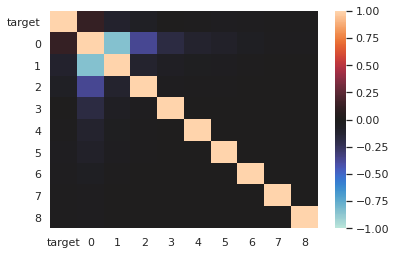

,target,has_mention
target,1.000000,-0.118716
has_mention,-0.118716,1.000000


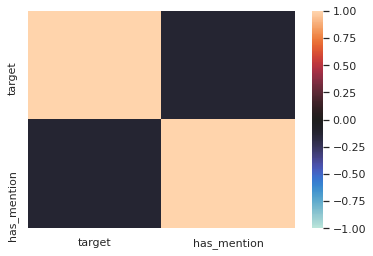

In [ ]:
max_mentions = text_mentions.apply(len).max()
target_text_mention_count_corr = pd.concat([train.target, *[text_mentions.apply(len).apply(lambda x: 1 if x==cnt else 0) for cnt in range(max_mentions + 1)]], axis=1, keys=['target', *range(max_mentions + 1)]).corr()

display(target_text_mention_count_corr)
sns.heatmap(target_text_mention_count_corr, vmax=1, vmin=-1, center=0)
plt.show()

target_text_has_mention_corr = pd.concat([train.target, text_mentions.apply(len).apply(lambda x: 1 if x > 0 else 0)], axis=1, keys=['target', 'has_mention']).corr()

display(target_text_has_mention_corr)
sns.heatmap(target_text_has_mention_corr, vmax=1, vmin=-1, center=0)

すると、強いていうならメンションが1つもない物の方がターゲットになっていそうかもということが言えそうだが、微々たる物ように感じる。
-> メンションがあるとターゲットの割合が下がる？

## hashtagとtargetの関係

In [ ]:
uniq_hashtag = set()

for hashtags in text_hashtags:
    for hashtag in hashtags:
        uniq_hashtag.add(hashtag.lower())

uniq_hashtag = list(uniq_hashtag)
print(len(uniq_hashtag))

1926


約2000以上ものハッシュタグがある。ただ、ハッシュタグは大文字小文字などの違いをなくしても1923種類もあるようだ。

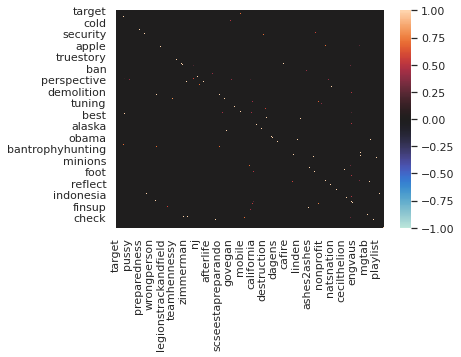

In [ ]:
target_text_hashtags_corr = pd.concat([train.target, *[text_hashtags.apply(lambda hashtags: 1 if hashtag in hashtags else 0) for hashtag in uniq_hashtag]], axis=1, keys=['target', *uniq_hashtag]).corr()
sns.heatmap(target_text_hashtags_corr, vmax=1, vmin=-1, center=0)


In [ ]:
target_text_hashtags_corr.target.reindex(target_text_hashtags_corr.target.abs().sort_values(ascending=False).index).head()

target        1.000000
hiroshima     0.062025
news          0.058908
earthquake    0.057630
japan         0.043827
Name: target, dtype: float64

hashtagもtargetに対して関係性が深いと言えそうなものはなさそうだ

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13
target,1.000000,-0.068903,0.050913,0.039078,0.011902,-0.009678,0.019488,-0.020536,0.008688,0.029178,-0.014070,0.019806,-0.014070,NaN,0.026416
0,-0.068903,1.000000,-0.698764,-0.436134,-0.302976,-0.178056,-0.131686,-0.109483,-0.055673,-0.059520,-0.029748,-0.066555,-0.029748,NaN,-0.042076
1,0.050913,-0.698764,1.000000,-0.090492,-0.062863,-0.036944,-0.027323,-0.022716,-0.011551,-0.012350,-0.006172,-0.013809,-0.006172,NaN,-0.008730
2,0.039078,-0.436134,-0.090492,1.000000,-0.039236,-0.023059,-0.017054,-0.014178,-0.007210,-0.007708,-0.003853,-0.008619,-0.003853,NaN,-0.005449
3,0.011902,-0.302976,-0.062863,-0.039236,1.000000,-0.016019,-0.011847,-0.009849,-0.005009,-0.005355,-0.002676,-0.005987,-0.002676,NaN,-0.003785
4,-0.009678,-0.178056,-0.036944,-0.023059,-0.016019,1.000000,-0.006962,-0.005788,-0.002943,-0.003147,-0.001573,-0.003519,-0.001573,NaN,-0.002225
5,0.019488,-0.131686,-0.027323,-0.017054,-0.011847,-0.006962,1.000000,-0.004281,-0.002177,-0.002327,-0.001163,-0.002602,-0.001163,NaN,-0.001645
6,-0.020536,-0.109483,-0.022716,-0.014178,-0.009849,-0.005788,-0.004281,1.000000,-0.001810,-0.001935,-0.000967,-0.002164,-0.000967,NaN,-0.001368
7,0.008688,-0.055673,-0.011551,-0.007210,-0.005009,-0.002943,-0.002177,-0.001810,1.000000,-0.000984,-0.000492,-0.001100,-0.000492,NaN,-0.000696
8,0.029178,-0.059520,-0.012350,-0.007708,-0.005355,-0.003147,-0.002327,-0.001935,-0.000984,1.000000,-0.000526,-0.001176,-0.000526,NaN,-0.000744


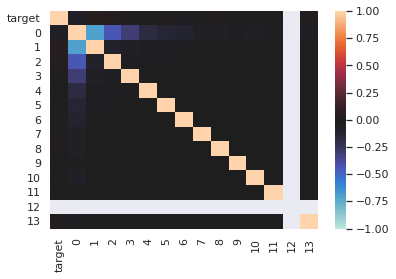

,target,has_hashtag
target,1.000000,0.068903
has_hashtag,0.068903,1.000000


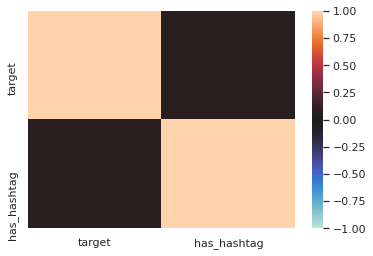

In [ ]:
max_hashtags = text_hashtags.apply(len).max()
target_text_hashtag_count_corr = pd.concat([train.target, *[text_hashtags.apply(len).apply(lambda x: 1 if x==cnt else 0) for cnt in range(max_hashtags + 1)]], axis=1, keys=['target', *range(max_hashtags + 1)]).corr()

display(target_text_hashtag_count_corr)
sns.heatmap(target_text_hashtag_count_corr, vmax=1, vmin=-1, center=0)
plt.show()

target_text_hash_hashtag_corr = pd.concat([train.target, text_hashtags.apply(len).apply(lambda x: 1 if x > 0 else 0)], axis=1, keys=['target', 'has_hashtag']).corr()
display(target_text_hash_hashtag_corr)
sns.heatmap(target_text_hash_hashtag_corr, vmax=1, vmin=-1, center=0)

hashtagの個数についてもmentionの時と同じことが言えそうだ。

## urlとtextの関係

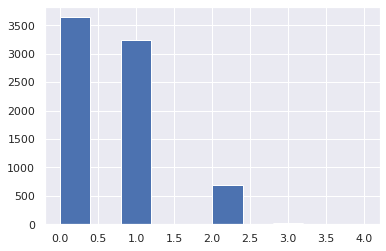

,target,0,1,2,3,4
target,1.000000,-0.247440,0.235534,0.026247,-0.002237,-0.017233
0,-0.247440,1.000000,-0.826328,-0.304025,-0.051556,-0.019015
1,0.235534,-0.826328,1.000000,-0.273919,-0.046451,-0.017132
2,0.026247,-0.304025,-0.273919,1.000000,-0.017090,-0.006303
3,-0.002237,-0.051556,-0.046451,-0.017090,1.000000,-0.001069
4,-0.017233,-0.019015,-0.017132,-0.006303,-0.001069,1.000000


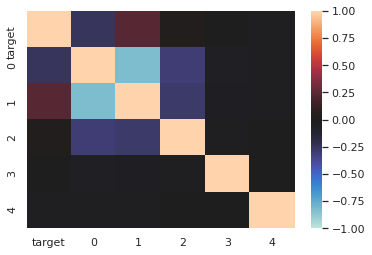

,target,has_url
target,1.00000,0.24744
has_url,0.24744,1.00000


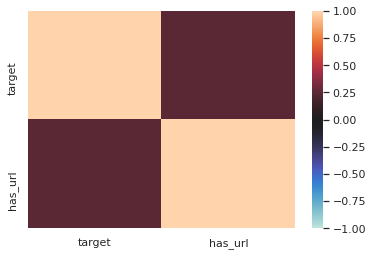

In [ ]:
max_urls = text_url.apply(len).max()
target_text_url_count_corr = pd.concat([train.target, *[text_url.apply(len).apply(lambda x: 1 if x==cnt else 0) for cnt in range(max_urls + 1)]], axis=1, keys=['target', *range(max_urls + 1)]).corr()

text_url.apply(len).hist()
plt.show()
display(target_text_url_count_corr)
sns.heatmap(target_text_url_count_corr, vmax=1, vmin=-1, center=0)
plt.show()

target_text_has_url_corr = pd.concat([train.target, text_url.apply(len).apply(lambda x: 1 if x > 0 else 0)], axis=1, keys=['target', 'has_url']).corr()

display(target_text_has_url_corr)
sns.heatmap(target_text_has_url_corr, vmax=1, vmin=-1, center=0)

おお？

urlが
- 0個だと`target`に負の傾向がある
- 1個だと`target`に正の傾向がある

ことが言えそうだ。

## textのクリーンアップ

textに含まれているhashタグやurl、メンションを削除する

In [ ]:
def text_remove_mention_url_hash(text: str):
    return text_remove_hashtags(text_remove_mentions(text_remove_url(text.replace('\n', ' '))))

removed_text = train.text.apply(text_remove_mention_url_hash)

for i, (t1, t2) in enumerate(zip(train.text, removed_text)):
    if i > 100:
        break
    print(t1)
    print(t2)
    print()

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Our Deeds are the Reason of this  May ALLAH Forgive us all

Forest fire near La Ronge Sask. Canada
Forest fire near La Ronge Sask. Canada

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

13,000 people receive #wildfires evacuation orders in California 
13,000 people receive  evacuation orders in California 

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Just got sent this photo from Ruby  as smoke from  pours into a school 

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
 Update => California Hwy. 20 closed in both directions due to Lake County fire -  

#flood #disaster Heavy rain causes flash 

# 分析１

## ルールベースで分類

hashtagとmentionでその値があるかないかでtargetの割合が大きく変わるものをピックアップする。

In [ ]:
target_1_hashtag = set()
target_0_hashtag = set()

for hashtag in uniq_hashtag:
    _temp = train[text_hashtags.apply(lambda x: hashtag in x)]
    if len(_temp) < 4:
        continue
    score = (_temp.target.mean() - 0.5) * 2
    if score >= 0.7:
        target_1_hashtag.add(hashtag)
    if score <= -0.7:
        target_0_hashtag.add(hashtag)

print('target_1_hashtag')
print(target_1_hashtag)
print('\ntarget_0_hashtag')
print(target_0_hashtag)

target_1_hashtag
{'breaking', 'hailstorm', 'fukushima', 'newyork', 'hostages', 'disaster', 'worldnews', 'rockyfire', 'africa', 'myanmar', 'flood', 'wildfire', 'genocide', 'japan', 'yyc', 'mumbai', 'rohingya', 'wx', 'antioch', 'mh370', 'sandiego', 'sismo', 'earthquake', 'jap', 'wildfires', 'terrorist', 'weather', 'abstorm', 'libya', 'accident', 'india', 'manchester', 'zionist', 'hiroshima', 'bestnaijamade', 'science', 'okwx', 'socialnews', 'sittwe', 'idfire'}

target_0_hashtag
{'hiring', 'ices', 'directioners', 'jobs', 'job', 'nsfw', 'mayhem', 'beyhive', 'bb17', 'trapmusic', 'chemical', 'mtvhottest', 'soundcloud', 'bluejays', 'dubstep', 'dnb', 'handbag', '7', 'dependency', 'edm', 'military', 'ramag', 'fashion', 'animalrescue', 'dance', 'summerfate', 'models', 'technology', 'np', 'free', 'nowplaying', 'emmerdale', 'kindle'}


In [ ]:
target_1_mention = set()
target_0_mention = set()

for mention in uniq_mention:
    _temp = train[text_mentions.apply(lambda x: mention in x)]
    if len(_temp) < 4:
        continue
    score = (_temp.target.mean() - 0.5) * 2
    if score >= 0.7:
        target_1_mention.add(mention)
    if score <= -0.7:
        target_0_mention.add(mention)

print('target_1_mention')
print(target_1_mention)
print('\ntarget_0_mention')
print(target_0_mention)

target_1_mention
{'unsuckdcmetro', 'USAgov', 'FoxNews', 'AP'}

target_0_mention
{'MikeParrActor', 'LoneWolffur', 'Grazed', 'DiamondKesawn', 'RaynbowAffair', 'justinbieber', 'local_arsonist', 'ArianaGrande', 'emmerdale', 'djicemoon', 'worldnetdaily', 'invalid'}


ルール->

- hashtagの内1つでも`target_1_hashtag`に存在すれば１（もしくは０)
- mentionの内1つでも`target_1_mention`に存在すれば1（もしくは０）
- それ以外は乱数が0.5以上なら1

In [ ]:
import random

def rule1(text):
    if any((hashtag in target_1_hashtag for hashtag in text_to_hashtags(text))):
        return 1
    if any((hashtag in target_0_hashtag for hashtag in text_to_hashtags(text))):
        return 0
    if any((mention in target_1_mention for mention in text_to_mentions(text))):
        return 1
    if any((mention in target_0_mention for mention in text_to_mentions(text))):
        return 0
    return random.randint(0,1)

result1 = pd.DataFrame({'id': test.id, 'target': test.text.apply(rule1)})
result1.to_csv('./submission_1.csv', index=False)
display(result1)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


結果は0.51だった。つまり、sample submittionも方が成績が良いということになった

## 原因分析

なぜスコアが低いか分析する。
1. 該当するメンション、ハッシュタグのものが少なくて、実質ランダム状態だった。
2. ルールがよくなかった

### 原因分析１ testでメンション、ハッシュタグで該当したものを数え上げる

In [ ]:
def rule1_count(text):
    if any((hashtag in target_1_hashtag for hashtag in text_to_hashtags(text))):
        return 1
    if any((hashtag in target_0_hashtag for hashtag in text_to_hashtags(text))):
        return 1
    if any((mention in target_1_mention for mention in text_to_mentions(text))):
        return 1
    if any((mention in target_0_mention for mention in text_to_mentions(text))):
        return 1
    return 0

test.text.apply(rule1_count).describe()


count    3263.000000
mean        0.052712
std         0.223493
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: text, dtype: float64

{'abstorm',
 'accident',
 'africa',
 'antioch',
 'bestnaijamade',
 'breaking',
 'disaster',
 'earthquake',
 'flood',
 'fukushima',
 'genocide',
 'hailstorm',
 'hiroshima',
 'hostages',
 'idfire',
 'india',
 'jap',
 'japan',
 'libya',
 'manchester',
 'mh370',
 'mumbai',
 'myanmar',
 'newyork',
 'okwx',
 'rockyfire',
 'rohingya',
 'sandiego',
 'science',
 'sismo',
 'sittwe',
 'socialnews',
 'terrorist',
 'weather',
 'wildfire',
 'wildfires',
 'worldnews',
 'wx',
 'yyc',
 'zionist'}

該当するものは±合わせて5%ほどだった。これではほとんど乱数になってしまっている。

## 分析1.1

もう少したくさんのものが該当するようにする

In [ ]:
def make_target_hashtag(threshold):
    target_1_hashtag = set()
    target_0_hashtag = set()

    for hashtag in uniq_hashtag:
        _temp = train[text_hashtags.apply(lambda x: hashtag in x)]
        if len(_temp) < 4:
            continue
        score = (_temp.target.mean() - 0.5) * 2
        if score >= threshold:
            target_1_hashtag.add(hashtag)
        if score <= -threshold:
            target_0_hashtag.add(hashtag)
    return target_1_hashtag, target_0_hashtag

def make_target_mention(threshold):
    target_1_mention = set()
    target_0_mention = set()

    for mention in uniq_mention:
        _temp = train[text_mentions.apply(lambda x: mention in x)]
        if len(_temp) < 2:
            continue
        score = (_temp.target.mean() - 0.5) * 2
        if score >= threshold:
            target_1_mention.add(mention)
        if score <= -threshold:
            target_0_mention.add(mention)
    return target_1_mention, target_0_mention

target_1_1_hashtag, target_0_1_hashtag = make_target_hashtag(0.05)
target_1_1_mention, target_0_1_mention = make_target_mention(0.05)

In [ ]:
def rule1_count_1(text):
    if any((hashtag in target_1_1_hashtag for hashtag in text_to_hashtags(text))):
        return 1
    if any((hashtag in target_0_1_hashtag for hashtag in text_to_hashtags(text))):
        return 1
    if any((mention in target_1_1_mention for mention in text_to_mentions(text))):
        return 1
    if any((mention in target_0_1_mention for mention in text_to_mentions(text))):
        return 1
    return 0

test.text.apply(rule1_count_1).describe()

count    3263.000000
mean        0.114618
std         0.318610
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: text, dtype: float64

In [ ]:
len(test[(test.text.apply(text_to_hashtags).apply(len) > 0) | (test.text.apply(text_to_mentions).apply(len) > 0)])

1549

In [ ]:
len(test)

3263

In [ ]:
train[text_mentions.apply(lambda x: 'USAgov' in x)]

,id,keyword,location,text,target
614,885,bioterrorism,NaN,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...,1
628,905,bioterrorism,NaN,@StationCDRKelly Any Support Sys 4 @USAgov AUT...,1
633,915,bioterrorism,NaN,@HowardU If 90BLKs&amp;8WHTs colluded 2 take W...,1
635,919,bioterrorism,NaN,@cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...,1
4409,6268,hijacking,NaN,@USAgov Koreans are performing hijacking of th...,1


In [ ]:
hashtag_target_map = {
    'science', 'bbc', 'bestnaijamade', 'earthquake', 'india', 'hailstorm', 'myanmar', 'worldnews',
    'antioch', 'africa', 'disaster'
}

0                                       [earthquake]
3                                        [wildfires]
4                                [alaska, wildfires]
5                     [rockyfire, cafire, wildfires]
6                                  [flood, disaster]
11                                        [flooding]
12     [raining, flooding, florida, tampabay, tampa]
13                                       [flood, we]
14                                        [breaking]
32                                       [metal, rt]
33                                     [africanbaze]
36                                            [mufc]
38                                      [bridgetown]
40                                            [nsfw]
48                                            [nsfw]
55                                   [kurds, diyala]
59                     [california, climate, energy]
64                                 [nowplaying, edm]
68                                [nashvilletr